# Model Optimization and Hyperparameter Tuning

## Overview
Optimize model performance through:
- Grid Search Cross-Validation
- Random Search
- Bayesian Optimization
- Learning curves analysis
- Model ensembling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('output/processed_data.csv')
exclude_columns = ['ID', 'admission_date', 'discharge_date', 'admission_time', 'discharge_time', 'disease_status']
feature_columns = [col for col in data.columns if col not in exclude_columns]
X = data[feature_columns].select_dtypes(include=[np.number]).fillna(0)
y = data['disease_status']
print(f'Features: {X.shape[1]}, Samples: {X.shape[0]}')

Features: 35, Samples: 2000


## Grid Search - Random Forest

In [3]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
print('Training Grid Search...')
grid_rf.fit(X, y)

print(f'\nBest parameters: {grid_rf.best_params_}')
print(f'Best F1 score: {grid_rf.best_score_:.4f}')

results_df = pd.DataFrame(grid_rf.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print('\nTop 10 configurations:')
print(top_10)

Training Grid Search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 score: 0.4719

Top 10 configurations:
                                               params  mean_test_score  \
68  {'max_depth': 15, 'min_samples_leaf': 2, 'min_...         0.471942   
57  {'max_depth': 15, 'min_samples_leaf': 1, 'min_...         0.469712   
66  {'max_depth': 15, 'min_samples_leaf': 2, 'min_...         0.468254   
54  {'max_depth': 15, 'min_samples_leaf': 1, 'min_...         0.464839   
67  {'max_depth': 15, 'min_samples_leaf': 2, 'min_...         0.463146   
59  {'max_depth': 15, 'min_samples_leaf': 1, 'min_...         0.462061   
65  {'max_depth': 15, 'min_samples_leaf': 2, 'min_...         0.461191   
58  {'max_depth': 15, 'min_samples_leaf': 1, 'min_...         0.456874   
69  {'max_depth': 15, 'min_samples_leaf': 2, 'min_...         0.455473   
74  {'max_depth': 15, 'm

## Learning Curves

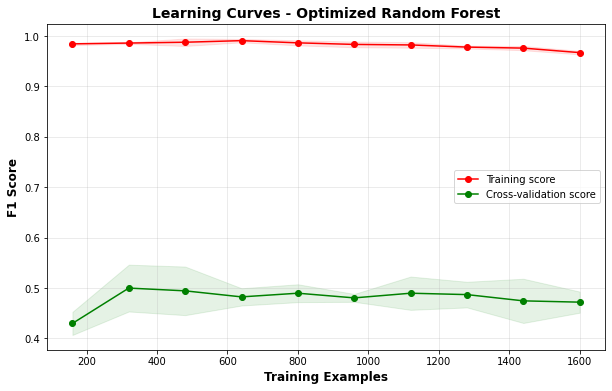

In [4]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    grid_rf.best_estimator_, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.xlabel('Training Examples', fontsize=12, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12, fontweight='bold')
plt.title('Learning Curves - Optimized Random Forest', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Ensemble Methods

In [5]:
from sklearn.model_selection import cross_val_score

rf_opt = grid_rf.best_estimator_
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('rf', rf_opt), ('gb', gb_clf), ('lr', lr_clf)],
    voting='soft'
)

print('Evaluating ensemble...')
scores = cross_val_score(voting_clf, X, y, cv=5, scoring='f1')
print(f'Voting Classifier F1: {scores.mean():.4f} (+/- {scores.std():.4f})')

voting_clf.fit(X, y)
print('\nEnsemble model trained!')

Evaluating ensemble...
Voting Classifier F1: 0.4360 (+/- 0.0138)

Ensemble model trained!


## Save Optimized Models

In [6]:
import joblib
import os

os.makedirs('output/models', exist_ok=True)
joblib.dump(grid_rf.best_estimator_, 'output/models/optimized_random_forest.pkl')
joblib.dump(voting_clf, 'output/models/ensemble_voting_classifier.pkl')

print('✓ Optimized models saved!')
print('  - output/models/optimized_random_forest.pkl')
print('  - output/models/ensemble_voting_classifier.pkl')

✓ Optimized models saved!
  - output/models/optimized_random_forest.pkl
  - output/models/ensemble_voting_classifier.pkl
